In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import xml.etree.ElementTree as ET
from PIL import Image

In [6]:
class MobileDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, classes=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.annotation_files = [f.replace('.png', '.xml') for f in self.image_files]

        # Collect classes from all annotations
        if classes is None:
            self.classes = []
            for xml_file in self.annotation_files:
                xml_path = os.path.join(annotation_dir, xml_file)
                tree = ET.parse(xml_path)
                root = tree.getroot()
                for obj in root.iter('object'):
                    cls_name = obj.find('name').text
                    if cls_name not in self.classes:
                        self.classes.append(cls_name)
            self.classes = sorted(self.classes)
        else:
            self.classes = classes

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Load annotations
        xml_path = os.path.join(self.annotation_dir, self.annotation_files[idx])
        boxes, labels = self.parse_xml(xml_path)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target

    def parse_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.iter('object'):
            cls_name = obj.find('name').text
            if cls_name not in self.classes:
                continue

            # Convert class name to index (add 1 for background class)
            cls_id = self.classes.index(cls_name) + 1

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(cls_id)

        return boxes, labels

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = MobileDataset(
    image_dir='/content/drive/MyDrive/1/images',
    annotation_dir='/content/drive/MyDrive/1/annotations',
    transform=transform
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace classifier with custom head
num_classes = len(dataset.classes) + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 184MB/s]


In [8]:
# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs} Loss: {total_loss/len(data_loader)}")

# Save trained model
torch.save(model.state_dict(), 'mobile_detection_model.pth')

Epoch 1/10 Loss: 0.19613683387637137
Epoch 2/10 Loss: 0.09349201418459416
Epoch 3/10 Loss: 0.05167112521827221
Epoch 4/10 Loss: 0.03754171997308731
Epoch 5/10 Loss: 0.03101423501968384
Epoch 6/10 Loss: 0.025622239224612712
Epoch 7/10 Loss: 0.021679394785314797
Epoch 8/10 Loss: 0.020596886947751046
Epoch 9/10 Loss: 0.018207171354442834
Epoch 10/10 Loss: 0.017276227809488773


<ipython-input-11-49c5871b1990>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobile_detection_model.pth'))


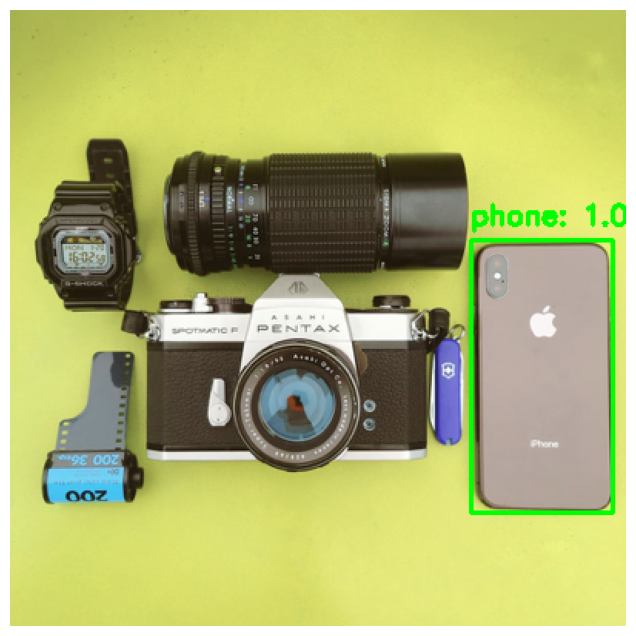

In [11]:
def predict(image_path, model, dataset, confidence_threshold=0.5):
    # Load image
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img)

    # Transform image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor)

    # Process predictions
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    # Filter predictions
    keep = (scores >= confidence_threshold) & (labels > 0)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep] - 1  # Convert to 0-based indices

    # Draw predictions
    for box, score, label in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box.astype(int)
        cv2.rectangle(original_img,
                     (xmin, ymin),
                     (xmax, ymax),
                     (0, 255, 0), 2)

        label_text = f"{dataset.classes[label]}: {score:.2f}"
        cv2.putText(original_img,
                   label_text,
                   (xmin, ymin-10),
                   cv2.FONT_HERSHEY_SIMPLEX,
                   0.6, (0, 255, 0), 2)

    # Convert to RGB for matplotlib
    result_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.show()

# Load trained model
model.load_state_dict(torch.load('mobile_detection_model.pth'))
model.eval()

# Test on new image
predict('/content/phones188.png', model, dataset, confidence_threshold=0.5)